In [1]:
#1. Import Libraries & Load Dataset

First 5 rows of data:
  shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
0                             burgers,meatballs,eggs                                                                                                                                                                             
1                                            chutney                                                                                                                                                                             
2                                     turkey,avocado                                                                                                                                                                             
3  mineral water,milk,energy bar,whole wheat rice...                      

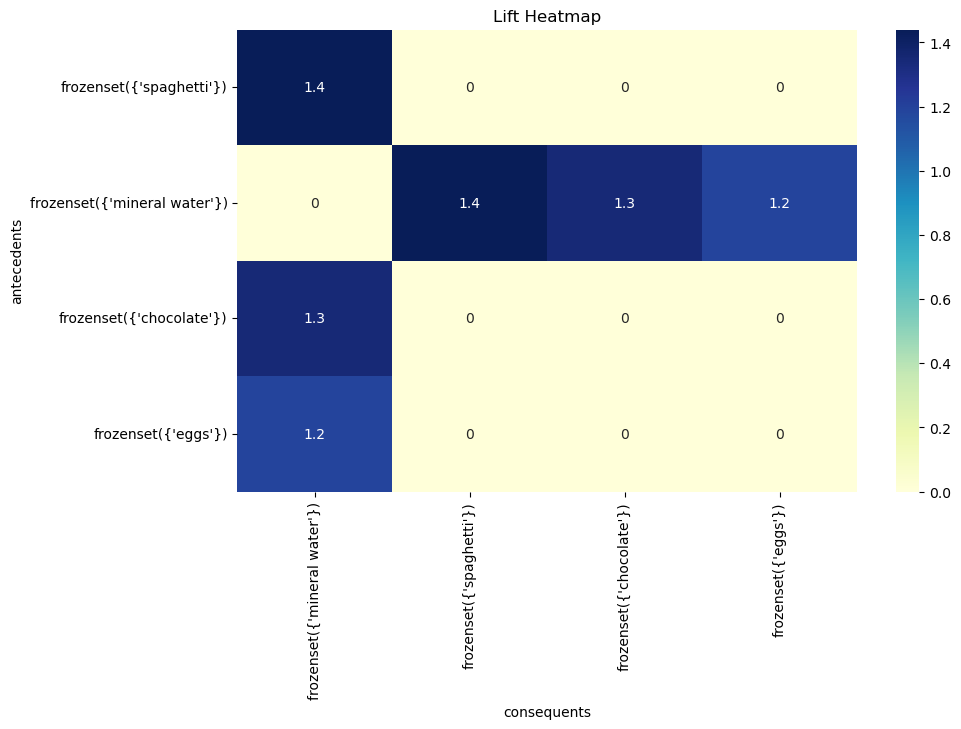

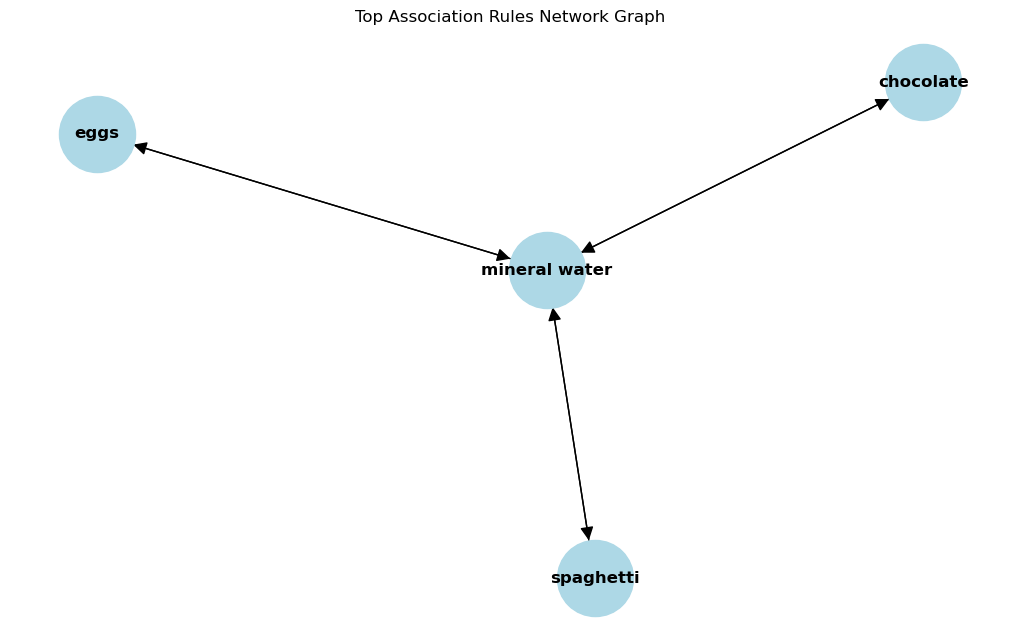

In [17]:

import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# ----------------------
# 1. Load Dataset
# ----------------------
file_path = "online retail.csv"
data = pd.read_csv(file_path)

print("First 5 rows of data:")
print(data.head())

# ----------------------
# 2. Data Preprocessing
# ----------------------
# Check columns
print("\nColumns:", data.columns)

# If all items are in a single column separated by commas, split them into transactions
# Assuming your data looks like "shrimp,almonds,avocado,..."
transactions = []
for index, row in data.iterrows():
    items = str(row.iloc[0]).split(",")
    transactions.append([item.strip() for item in items])

print("\nExample transaction:", transactions[0])

# ----------------------
# 3. Convert transactions into One-Hot Encoded DataFrame
# ----------------------
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)
print("\nOne-hot encoded shape:", df.shape)

# ----------------------
# 4. Apply Apriori Algorithm
# ----------------------
frequent_itemsets = apriori(df, min_support=0.05, use_colnames=True)  # min_support = 5%
frequent_itemsets = frequent_itemsets.sort_values(by="support", ascending=False)
print("\nFrequent Itemsets:")
print(frequent_itemsets.head())

# ----------------------
# 5. Generate Association Rules
# ----------------------
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values(by="lift", ascending=False)
print("\nTop 10 Association Rules:")
print(rules.head(10))

# ----------------------
# 6. Remove Redundant Rules
# ----------------------
def remove_redundant(rules):
    redundant = []
    for i in range(len(rules)):
        for j in range(len(rules)):
            if i != j and rules.iloc[i]['antecedents'].issubset(rules.iloc[j]['antecedents']) and \
               rules.iloc[i]['consequents'].issubset(rules.iloc[j]['consequents']):
                redundant.append(i)
    return rules.drop(redundant)

rules = remove_redundant(rules)
print("\nRules after removing redundancy:", rules.shape)

# ----------------------
# 7. Optimize Thresholds (Adjusted)
# ----------------------
# Lower the thresholds to get some rules
rules_filtered = rules[(rules['support'] >= 0.01) & (rules['confidence'] >= 0.2) & (rules['lift'] > 1)]
print("\nFiltered Rules (Support>=0.01, Confidence>=0.2, Lift>1):")
print(rules_filtered.head(10))

# ----------------------
# 8. Visualize Top Rules using Heatmap
# ----------------------
if not rules_filtered.empty:
    pivot_table = rules_filtered.pivot_table(index='antecedents', columns='consequents', values='lift', fill_value=0)
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, cmap="YlGnBu", annot=True)
    plt.title("Lift Heatmap")
    plt.show()
else:
    print("\n⚠ No rules to visualize for given thresholds. Try reducing thresholds.")

# ----------------------
# 9. Visualize Top Rules using Network Graph
# ----------------------
top_rules = rules_filtered.head(10)

G = nx.DiGraph()
for _, rule in top_rules.iterrows():
    for a in rule['antecedents']:
        for c in rule['consequents']:
            G.add_edge(a, c, weight=rule['lift'])

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=12, font_weight='bold', arrowsize=20)
plt.title("Top Association Rules Network Graph")
plt.show()


Interview Questions:


1.	What is lift and why is it important in Association rules?
Definition:
Lift measures how much more likely item A and B occur together compared to if they were independent.

Lift
(
𝐴
→
𝐵
)
=
Support
(
𝐴
∪
𝐵
)
Support
(
𝐴
)
×
Support
(
𝐵
)
Lift(A→B)=
Support(A)×Support(B)
Support(A∪B)
	​


Importance:

Lift > 1 → Positive correlation (A and B occur together more than expected).

Lift = 1 → No correlation (independent).

Lift < 1 → Negative correlation (A and B rarely occur together).

Why important?
It helps identify non-trivial and meaningful rules by removing those that occur together just by chance.

2. What is Support and Confidence? How do you calculate them?

Support:

The proportion of transactions containing both A and B.

Support
(
𝐴
∪
𝐵
)
=
Number of transactions containing A and B
Total transactions
Support(A∪B)=
Total transactions
Number of transactions containing A and B
	​


Confidence:

Probability that B occurs given A occurs.

Confidence
(
𝐴
→
𝐵
)
=
Support
(
𝐴
∪
𝐵
)
Support
(
𝐴
)
Confidence(A→B)=
Support(A)
Support(A∪B)
	​


Example:
If 100 transactions,

20 have Milk, 15 have Bread, 10 have both.

Support
(
𝑀
𝑖
𝑙
𝑘
∪
𝐵
𝑟
𝑒
𝑎
𝑑
)
=
10
/
100
=
0.10
Confidence
(
𝑀
𝑖
𝑙
𝑘
→
𝐵
𝑟
𝑒
𝑎
𝑑
)
=
10
/
20
=
0.50
Support(Milk∪Bread)=10/100=0.10Confidence(Milk→Bread)=10/20=0.50

3. What are some limitations or challenges of Association Rule Mining?

1.Large search space – Many possible item combinations → computationally expensive.
2.Sparse data – Many rules may have very low support.
3. Meaningless rules – Some rules might be statistically strong but practically useless.
4.Choosing thresholds – Setting support/confidence thresholds too high or too low affects rule quality.
5.Does not capture causality – Only correlation, not cause-effect.
6.Imbalanced items – Frequent items dominate, rare but important items might be ignored.